# Actions ~ BayesRL(X)

Illustrate how the model drives behaviour.


------

```
author:     Zach Wolpe
email:      zach.wolpe@medibio.com.au
date:       23 March 2022
```

-----


In [2]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
from tqdm import tqdm
import pandas as pd
import numpy as np
import arviz as az
import pickle 
import math

In [3]:
data_loc    = '/Users/zachwolpe/Documents/Production/Dynocog/Python Implementation/final instance/data objects/final data objects'
model_loc   = '/Users/zachwolpe/Documents/Production/Dynocog/Python Implementation/final instance/data objects/final model objects'

# load data

In [4]:

# bio models -----*
bio_model_top = np.load(model_loc + '/null_model_top.npz', allow_pickle=True)
bio_model_ran = np.load(model_loc + '/null_model_ran.npz', allow_pickle=True)

# wcst data -----*
wcst_top100     = pd.read_csv(data_loc + '/df_wcst_top_100.csv')
wcst_ran100     = pd.read_csv(data_loc + '/df_wcst_ran_100.csv')

# psychological covariates -----*
psy_top100     = pd.read_csv(data_loc + '/psy_covars_top100.csv')
psy_ran100     = pd.read_csv(data_loc + '/psy_covars_ran100.csv')

# demographic covariates -----*
dem_top100     = pd.read_csv(data_loc + '/dem_covars_top100.csv')
dem_ran100     = pd.read_csv(data_loc + '/dem_covars_ran100.csv')
# Bayesian Posterior Analysis

# extract data ----------------------------------------*
alpha   = pd.DataFrame.from_records(bio_model_top['arr_0'].tolist()['a'])
beta    = pd.DataFrame.from_records(bio_model_top['arr_0'].tolist()['b'])

a_mu  = bio_model_top['arr_0'].tolist()['a_mu']
b_mu  = bio_model_top['arr_0'].tolist()['b_mu']
a_sd  = bio_model_top['arr_0'].tolist()['a_sd_raw']
b_sd  = bio_model_top['arr_0'].tolist()['b_sd_raw']


def generate_data(bio_mod):
    alpha   = pd.DataFrame.from_records(bio_mod['arr_0'].tolist()['a'])
    beta    = pd.DataFrame.from_records(bio_mod['arr_0'].tolist()['b'])

    a_mu  = bio_mod['arr_0'].tolist()['a_mu']
    b_mu  = bio_mod['arr_0'].tolist()['b_mu']
    a_sd  = bio_mod['arr_0'].tolist()['a_sd_raw']
    b_sd  = bio_mod['arr_0'].tolist()['b_sd_raw']

    return {'alpha': alpha, 'beta': beta, 'a_mu': a_mu, 'b_mu': b_mu, 'a_sd': a_sd, 'b_sd': b_sd}

data = {}
data['top'] = generate_data(bio_model_top)
data['ran'] = generate_data(bio_model_ran)


In [5]:
# extract data ----------------------------------------*
alpha   = pd.DataFrame.from_records(bio_model_top['arr_0'].tolist()['a'])
beta    = pd.DataFrame.from_records(bio_model_top['arr_0'].tolist()['b'])

# first subject params 
a1 = alpha.loc[:,0].mean()
b1 = beta.loc[:,0].mean()

print('alpha: ', a1)
print('beta:  ', b1)

alpha:  0.9688441185927827
beta:   6.1801318205667135


In [10]:
# action distribution
wcst_top100.action.value_counts()

1.0    4334
3.0    3190
2.0    2429
Name: action, dtype: int64

In [12]:
# Generate action sequence --------------------------------------------------------------------------------------------*
def generate_Qs_pi(x,a,b):

    # init: [shape, colour, number]
    Qs = np.ones((100,4)) * 0.25

    for i in range(1,100):
        # take action
        at = x.action.values[i].astype(int)
        rt = x.reward.values[i].astype(int)

        # update
        Qs[i, at-1] = Qs[i-1, at-1] + a * (rt - Qs[i-1, at-1])

    # generated predicted actions
    pi = np.ones((100,4)) * 0.333
    pred = []

    for i in range(100):
        for j in [0,1,2,3]:
            pi[i, j] = np.exp(b * Qs[i,j]) / np.exp(b * Qs[i,]).sum()

        # predict
        pred.append(np.random.choice([1,2,3,4], size=1, p=pi[i,])[0])

    return {'Qs': Qs , 'pi':pi, 'pred':pred}
# Generate action sequence --------------------------------------------------------------------------------------------*



# Visualize action sequence -------------------------------------------------------------------------------------------*
def plot_data(actions, rewards, Qs):
    plt.figure(figsize=(30,3))
    x = np.arange(len(actions))

    plt.plot(x, Qs[:, 0] - .5 + 0, c='C0', lw=3, alpha=.3)
    plt.plot(x, Qs[:, 1] - .5 + 1, c='C1', lw=3, alpha=.3)
    plt.plot(x, Qs[:, 2] - .5 + 2, c='C2', lw=3, alpha=.3)

    s   = 50
    lw  = 2

    # action = 0
    print(actions)
    cond = (actions == 0) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C0', lw=lw)

    cond = (actions == 0) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C0', ec='C0', lw=lw)

    # action = 1
    cond = (actions == 1) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C1', lw=lw)

    cond = (actions == 1) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C1', ec='C1', lw=lw)

    # action = 2
    cond = (actions == 2) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C2', lw=lw)

    cond = (actions == 2) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C2', ec='C2', lw=lw)

    # provide legend 
    plt.scatter(0, 40, c='k', s=s, lw=lw, label='Reward')
    plt.scatter(0, 20, c='w', ec='k', s=s, lw=lw, label='No reward')
    plt.plot([0,1], [20,20], c='k', lw=3, alpha=.3, label='Qvalue (centered)')

    # axes
    plt.yticks([0,1,2], ['colour', 'shape', 'number'])
    plt.ylim(-1, 3)
    plt.ylabel('action: matching rule')
    plt.xlabel('trial')

    # legend
    handles, labels = plt.gca().get_legend_handles_labels()
    order   = (1,2,0)
    handles = [handles[idx] for idx in order]
    labels  = [labels[idx]  for idx in order]

    plt.legend(handles, labels, fontsize=20, loc=(1.01, .27))
    plt.tight_layout()
    return plt
# Visualize action sequence -------------------------------------------------------------------------------------------*

In [13]:
# Plot trajectory of participant:p ------------------------------------------------------------------------------------*
def fit_estimate(wcst, p, plot=False):
    x       = wcst.loc[wcst.participant==p,]
    p_no    = (x.index // 100)[0]

    # recover parameters estimate
    a = alpha.loc[:,p_no].mean()
    b = beta.loc[:,p_no].mean()

    # calculate
    res = generate_Qs_pi(x,a,b)
    pt  = None
    if plot:
        pt  = plot_data(x.action-1, x.reward, res['Qs'])
    
    # accuracy
    acc = np.mean(x.action == res['pred'])

    return {'res':res, 'pt':pt, 'acc':acc}
# Plot trajectory of participant:p ------------------------------------------------------------------------------------*

# Compute all results

In [31]:
wcst = wcst_top100.copy()

# compute best accuracy -----------------------------------*
pred_acc_top = []
for p in wcst.participant.unique():
    estimate = fit_estimate(wcst, p)
    pred_acc_top.append(estimate['acc'])


# compute accuracy in random set --------------------------*
wcst = wcst_ran100.copy()
pred_acc_ran    = []
reward_mean     = []
for p in wcst.participant.unique():
    estimate = fit_estimate(wcst, p)
    pred_acc_ran.append(estimate['acc'])

    # test: vs
    x = wcst.loc[wcst.participant==p,]
    reward_mean.append(x.reward.mean())



print('Average predicted vs reward accuracy: ', np.mean([i-j for i,j in zip(pred_acc_ran, reward_mean)]))
print('difference due to the 4th choice dimension (no rule)')

Average predicted vs reward accuracy:  -0.029000000000000005
difference due to the 4th choice dimension (no rule)


In [32]:
# fetch data ---------------------------------------------------*
wcst = wcst_top100.copy()                           # top sample 
wcst.loc[wcst.action.isna(), 'action'] = 4.0        # wcs

p = 388850.0
# p = wcst.participant.sample().values[0]

participant:  122240.0
Ave score:    0.83
1400    0.0
1401    0.0
1402    0.0
1403    0.0
1404    0.0
       ... 
1495    2.0
1496    2.0
1497    2.0
1498    2.0
1499    2.0
Name: action, Length: 100, dtype: float64


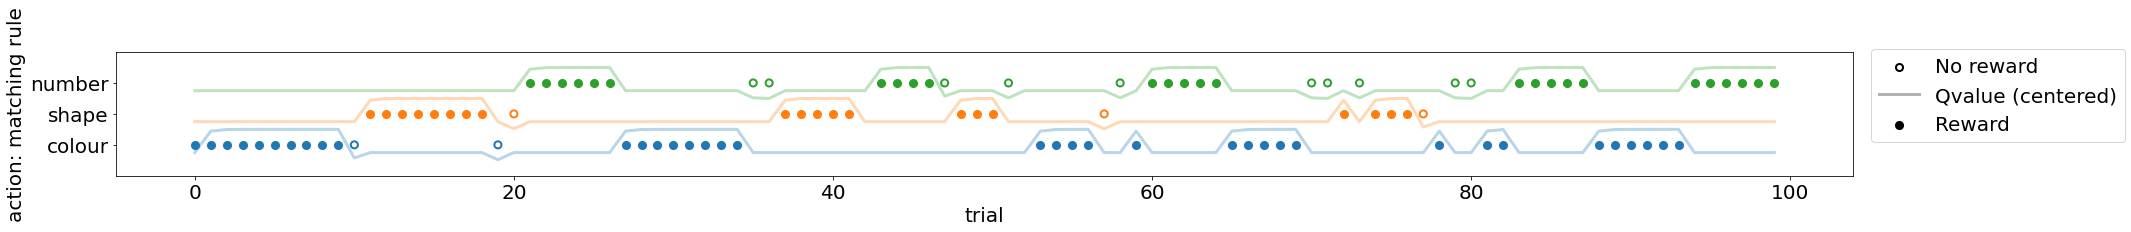

In [37]:
# find max -----------------------------------------------------*
max_idx = np.where(pred_acc_ran==np.max(pred_acc_ran))[0][0]
p = wcst.participant.unique()[max_idx]
p = np.random.choice(wcst.participant.unique())
print('participant: ', p)
print('Ave score:   ', wcst.loc[wcst.participant==p, ].reward.mean()) # 317920.0 # 702467.0 # 122240.0

# p = np.random.choice(wcst.participant.unique())
plt.rcParams.update({'font.size': 20})
r = fit_estimate(wcst, p, plot=True)

In [38]:

# Accuracy box plots -------------------------------------------------------------------------------------------------------------*

c1 = '#f7cac9'
c2 = '#f7cac9'
c3 = '#dec2cb'
c4 = '#c5b9cd'
c5 = '#abb1cf'
c6 = '#92a8d1'
import seaborn as sns
cls = sns.color_palette("flare", n_colors=3).as_hex()

c = 'steelblue'

fig = go.Figure()
fig.add_trace(go.Box(y=pred_acc_ran, name='random set',
                    marker_color='rgb(9,56,125)',
    line_color='rgb(9,56,125)'
                ))
fig.add_trace(go.Box(y=pred_acc_top, name = 'top set',
                marker_color = cls[2]
                ))


fig.update_layout(height=400, width=550, template='none')
fig.show()

In [39]:
# view best
print('top mean:    ', np.mean(pred_acc_top))
print('top median:  ', np.median(pred_acc_top))
print('---'*10)
print('ran mean:    ', np.mean(pred_acc_ran))
print('ran median:  ', np.median(pred_acc_ran))
print('ran max:     ', np.max(pred_acc_ran))
print('ran min:     ', np.min(pred_acc_ran))

top mean:     0.8068999999999998
top median:   0.81
------------------------------
ran mean:     0.7328
ran median:   0.75
ran max:      0.88
ran min:      0.4
